## Final Project Submission

Please fill out:
* Student name: Abigail Campbell
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL: 

### Topic 1: Recommendation Systems 
- make movie recommendations  
- based on the MovieLens dataset  
- from the GroupLens research lab at the University of Minnesota. 
- use the "small" dataset containing 100,000 user ratings (and potentially, only a particular subset of that dataset). 
 
#### Your task is to: 
- Build a model that provides top 5 movie recommendations to a user based on their ratings of other movies.  
- create the specific details about how the user will provide their ratings of other movies 
- formulate a more specific business problem within the general context of "recommending movies". 
 
#### Collaborative Filtering 
- At minimum, your recommendation system must use collaborative filtering 
- consider implementing a hybrid approach,  
- e.g. using collaborative filtering as the primary mechanism, but using content-based filtering to address the cold start problem. 
 
#### Evaluation 
- MovieLens dataset has explicit ratings  
- give some thought to the question of metrics.  
- Since the rankings are ordinal, we know we can treat this like a regression problem. 
- when it comes to regression metrics there are several choices: RMSE, MAE, etc.  

# Business Problem



## The Data

M

# Setup

### Import relevant packages

In [175]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import json

from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import train_test_split
from surprise import accuracy

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, mean_squared_error, r2_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load and Clean Data

In [2]:
# load raw csv files
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

preview Data, drop timestamp columns from all

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = ratings_df.drop(columns=['timestamp'], axis=1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
tags = tags_df.drop(columns=['timestamp'], axis=1)
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


## Total Dataset Visualizations

### Most common tags

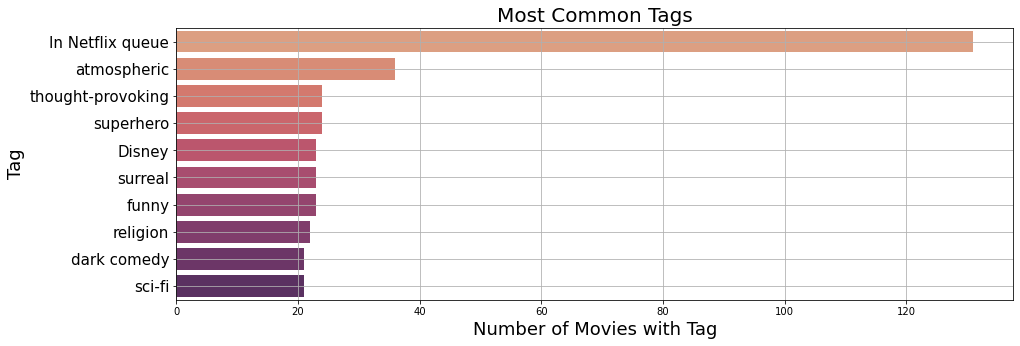

In [143]:
tags_group = tags.drop(columns='userId', axis=1)
tags_group = tags_group.groupby('tag').count().sort_values(by='movieId', ascending=False)
tags_group = tags_group.rename(columns={'movieId': 'Count'})
top_tag_groups = tags_group[:10]

plt.figure(figsize=(15,5))
sns.barplot(data=top_tag_groups, x='Count', y=top_tag_groups.index, palette='flare')
plt.yticks(fontsize=15)
plt.xlabel('Number of Movies with Tag', fontsize=18)
plt.ylabel('Tag', fontsize=18)
plt.title('Most Common Tags', fontsize=20)
plt.grid()

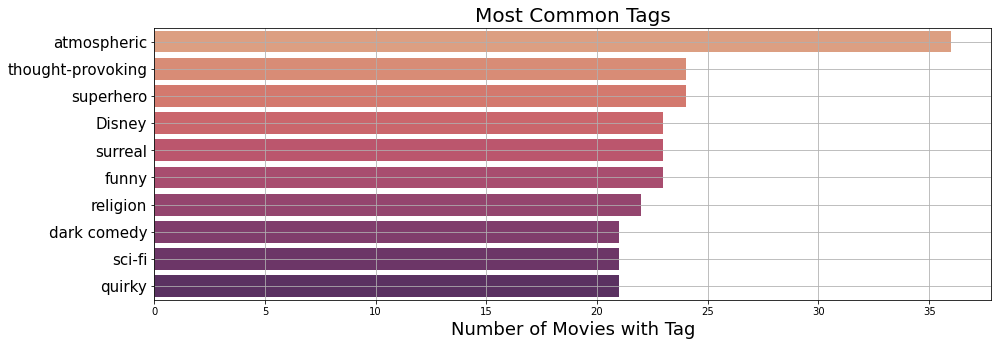

In [142]:
top_tag_groups = tags_group[1:11]

plt.figure(figsize=(15,5))
sns.barplot(data=top_tag_groups, x='Count', y=top_tag_groups.index, palette='flare')
plt.yticks(fontsize=15)
plt.xlabel('Number of Movies with Tag', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('Most Common Tags', fontsize=20)
plt.grid()

### Genre counts

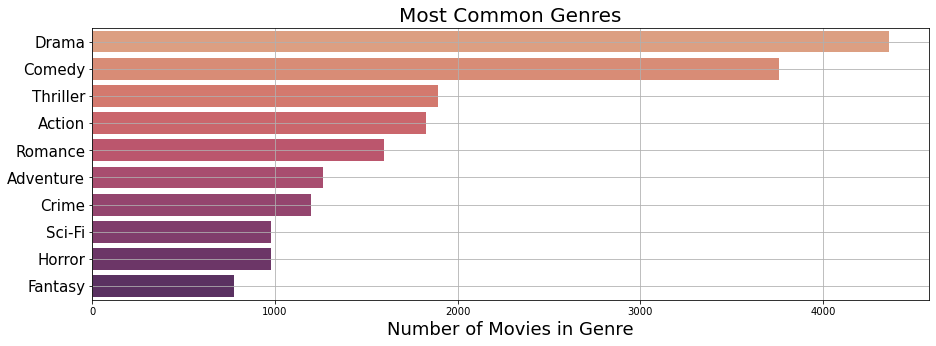

In [141]:
genres = movies_df.drop(columns=['title'], axis=1)

# convert genre tags to list
genres['genres'] = genres['genres'].map(lambda x: x.split('|'))
genres = genres.explode('genres')

genres_group = genres.groupby('genres').count().sort_values(by='movieId', ascending=False)
genres_group = genres_group.rename(columns={'movieId': 'Count'})
top_genres_group = genres_group[:10]

plt.figure(figsize=(15,5))
sns.barplot(data=top_genres_group, x='Count', y=top_genres_group.index, palette='flare')
plt.yticks(fontsize=15)
plt.xlabel('Number of Movies in Genre', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('Most Common Genres', fontsize=20)
plt.grid()

### Histogram of Ratings

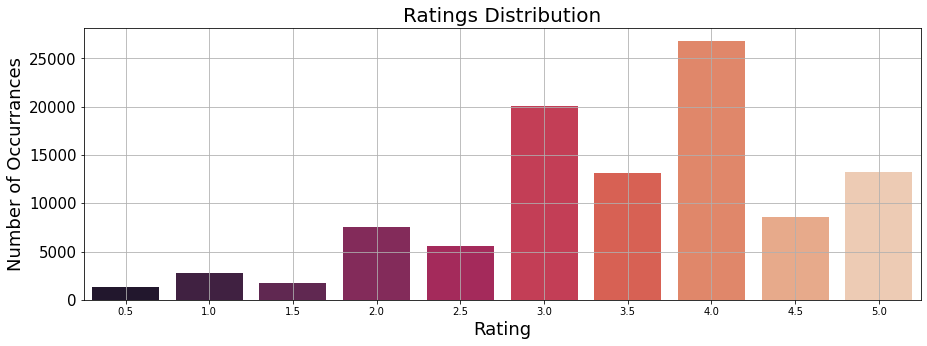

In [140]:
ratings_count = ratings.groupby("rating").count()
ratings_count.drop(columns=["userId"], axis=1)
ratings_count = ratings_count.rename(columns={'movieId': 'Count'})

plt.figure(figsize=(15,5))
sns.barplot(data=ratings_count, x=ratings_count.index, y='Count', palette="rocket")
plt.yticks(fontsize=15)
plt.xlabel('Rating', fontsize=18)
plt.ylabel('Number of Occurrances', fontsize=18)
plt.title('Ratings Distribution', fontsize=20)
plt.grid()

## Create a Surprise Dataset

goal:
- make recommendations for a given user id
- based on the movies they rated highly, recommend similar movies
- use movieId to get movie title after


In [6]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)

In [7]:
dataset = data.build_full_trainset()
print(f"N users = {dataset.n_users}")
print(f"N items = {dataset.n_items}")

N users = 610
N items = 9724


In [14]:
trainset, testset = train_test_split(data, test_size=0.2)

## Create a function to train and test each KNN method

In [15]:
sim_cos_item = {"name": "cosine", "user_based": False}
sim_pearson_item = {"name": "pearson", "user_based": False}
sim_cos_user = {"name": "cosine", "user_based": True}
sim_pearson_user = {"name": "pearson", "user_based": True}

In [161]:
def run_KNN_model(model_type, params):
    if model_type == 'KNNBasic':
        model = KNNBasic(sim_options=params, verbose=False)
    elif model_type == 'KNNBaseline':
        model = KNNBaseline(sim_options=params, verbose=False)
    elif model_type == 'KNNWithMeans':
        model = KNNWithMeans(sim_options=params, verbose=False)
    else:
        return 'not a model'

    model.fit(trainset)
    predictions = model.test(testset)
    accuracy_rmse = accuracy.rmse(predictions, verbose=False)
    accuracy_mae = accuracy.mae(predictions, verbose=False)
#     cv = cross_validate(model, data)
    
    return accuracy_rmse, accuracy_mae

## Train and Test KNN Basic Methods

In [167]:
basic_p_u_rmse, basic_p_u_mae = run_KNN_model("KNNBasic", sim_pearson_user)
print(f'basic pearson user: rmse = {round(basic_p_u_rmse, 4)}, mae = {round(basic_p_u_mae, 4)}')

basic_p_i_rmse, basic_p_i_mae = run_KNN_model("KNNBasic", sim_pearson_item)
print(f'basic pearson item: rmse = {round(basic_p_i_rmse, 4)}, mae = {round(basic_p_i_mae, 4)}')

basic_c_u_rmse, basic_c_u_mae = run_KNN_model("KNNBasic", sim_cos_user)
print(f'basic cosine user: rmse = {round(basic_c_u_rmse, 4)}, mae = {round(basic_c_u_mae, 4)}')

basic_c_i_rmse, basic_c_i_mae = run_KNN_model("KNNBasic", sim_cos_item)
print(f'basic cosine item: rmse = {round(basic_c_i_rmse, 4)}, mae = {round(basic_c_i_mae, 4)}')

basic pearson user: rmse = 0.9773, mae = 0.7532
basic pearson item: rmse = 0.9671, mae = 0.7522
basic cosine user: rmse = 0.9776, mae = 0.7507
basic cosine item: rmse = 0.9773, mae = 0.7623


## Train and Test KNN Baseline Methods

In [168]:
base_p_u_rmse, base_p_u_mae = run_KNN_model('KNNBaseline', sim_pearson_user)
print(f'baseline pearson user: rmse = {round(base_p_u_rmse, 4)}, mae = {round(base_p_u_mae, 4)}')

base_p_i_rmse, base_p_i_mae = run_KNN_model('KNNBaseline', sim_pearson_item)
print(f'baseline pearson item: rmse = {round(base_p_i_rmse, 4)}, mae = {round(base_p_i_mae, 4)}')

base_c_u_rmse, base_c_u_mae = run_KNN_model('KNNBaseline', sim_cos_user)
print(f'baseline cosine user: rmse = {round(base_c_u_rmse, 4)}, mae = {round(base_c_u_mae, 4)}')

base_c_i_rmse, base_c_i_mae = run_KNN_model('KNNBaseline', sim_cos_item)
print(f'baseline cosine item: rmse = {round(base_c_i_rmse, 4)}, mae = {round(base_c_i_mae, 4)}')

baseline pearson user: rmse = 0.8828, mae = 0.6739
baseline pearson item: rmse = 0.877, mae = 0.6767
baseline cosine user: rmse = 0.8839, mae = 0.6765
baseline cosine item: rmse = 0.8918, mae = 0.6893


## Train and Test KNN With Means Methods

In [169]:
means_p_u_rmse, means_p_u_mae = run_KNN_model('KNNWithMeans', sim_pearson_user)
print(f'means pearson user: rmse = {round(means_p_u_rmse, 4)}, mae = {round(means_p_u_mae, 4)}')

means_p_i_rmse, means_p_i_mae = run_KNN_model('KNNWithMeans', sim_pearson_item)
print(f'means pearson item: rmse = {round(means_p_i_rmse, 4)}, mae = {round(means_p_i_mae, 4)}')

means_c_u_rmse, means_c_u_mae = run_KNN_model('KNNWithMeans', sim_cos_user)
print(f'means cosine user: rmse = {round(means_c_u_rmse, 4)}, mae = {round(means_c_u_mae, 4)}')

means_c_i_rmse, means_c_i_mae = run_KNN_model('KNNWithMeans', sim_cos_item)
print(f'means cosine item: rmse = {round(means_c_i_rmse, 4)}, mae = {round(means_c_i_mae, 4)}')

means pearson user: rmse = 0.9014, mae = 0.6864
means pearson item: rmse = 0.9045, mae = 0.6883
means cosine user: rmse = 0.9052, mae = 0.693
means cosine item: rmse = 0.9065, mae = 0.6922


## Train and Test SVD Methods

In [176]:
grid_search_params = {'n_factors': [30, 40, 50, 60, 70, 80, 90, 100, 110],
                      'reg_all': [0.02, 0.04, 0.05, 0.06, 0.07, 0.1],
                      'n_epochs': [5, 10],
                      'lr_all': [0.005, 0.01]}
g_s_svd = GridSearchCV(SVD, param_grid=grid_search_params, n_jobs=-1)
g_s_svd.fit(data)

print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.869280583970683, 'mae': 0.6685759221765496}
{'rmse': {'n_factors': 80, 'reg_all': 0.05, 'n_epochs': 10, 'lr_all': 0.01}, 'mae': {'n_factors': 80, 'reg_all': 0.05, 'n_epochs': 10, 'lr_all': 0.01}}


## Define the Final Model

In [361]:
final_model = KNNBaseline(sim_options=sim_pearson_item, verbose=False)
# svd_best_rmse = g_s_svd.best_params['rmse']
# final_model = SVD(n_factors=svd_best_rmse ['n_factors'], reg_all=svd_best_rmse ['reg_all'], n_epochs=svd_best_rmse['n_epochs'] , lr_all=svd_best_rmse['lr_all'])
final_model.fit(dataset)

## Make Predictions

In [46]:
def rank_movies(userId):

    movies_list = []
    for movie_id in ratings.index.unique():
        user_prediction = final_model.predict(userId, movie_id)
        predicted_rating = user_prediction[3]
        movies_list.append((movie_id, predicted_rating))

    ranked_movies = sorted(movies_list, key=lambda x:x[1], reverse=True)
    
    return ranked_movies

In [47]:
def look_up_movie(movieId):
    title = movies_df[movies_df['movieId']==movieId]['title']
    title_string = title[title.index[0]]
    return title_string

In [48]:
def get_recommended_titles(n_recs, ranked_movies):
    return [look_up_movie(id[0]) for id in ranked_movies[0:n_recs]]

In [66]:
def recommend_to_user(userId, n_recs):
    ranked_movies = rank_movies(userId)
    recommended_titles = get_recommended_titles(n_recs, ranked_movies)
    return recommended_titles

In [362]:
user_id = 1
n_recs = 5
recommend_to_user(user_id, n_recs)

['Seven (a.k.a. Se7en) (1995)',
 'Usual Suspects, The (1995)',
 'Bottle Rocket (1996)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Shawshank Redemption, The (1994)']

## Cold Start Problem

## Recommend the top 5 highest rated movies and most rated movies
- movies with highest ratings with a certain # of ratings above
- continue until you have a threshold of ratings

In [398]:
# get average ratings and number of ratings for each movie id
ratings_avg = ratings.groupby('movieId').mean()
ratings_count = ratings.groupby('movieId').count()
ratings_avg.head()

# combine average and count into one stats dataframe
ratings_stats = ratings_avg.drop(columns='userId')
ratings_stats["n_ratings"] = ratings_count['userId']

# drop all movies with less than 10 ratings
ratings_stats = ratings_stats[ratings_stats['n_ratings'] > 50]

# order the movies by highest rank and highest number of ratings
ratings_stats_by_rating = ratings_stats.sort_values(by='rating', ascending=False)
ratings_stats_by_count = ratings_stats.sort_values(by='n_ratings', ascending=False)

In [399]:
def top_movies(n_movies, ratings):
    return [look_up_movie(movie_id) for movie_id in ratings[0:n_movies].index]

top_movies(5, ratings_stats_by_rating)
top_movies(5, ratings_stats_by_count)

['Forrest Gump (1994)',
 'Shawshank Redemption, The (1994)',
 'Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Matrix, The (1999)']

# Follow a User

In [324]:
user = 420

In [325]:
def get_user_ratings(userId):
    user_ratings = ratings[ratings.userId == userId]
    return user_ratings

In [248]:
def user_top_movies(user_ratings, n):
    top_titles = []
    for movieId in user_ratings[:n].movieId:
        top_titles.append(look_up_movie(movieId))
    return top_titles 

In [228]:
def look_up_tags(movieId):
    tags_list = tags[tags['movieId']==movieId]['tag']
    tags_string = []
    for tag in tags_list:
        tags_string.append(tag)
    return list(np.unique(np.array(tags_string)))

In [247]:
def user_top_movie_tags(user_ratings, n_movies):
    top_tags = []
    for movieId in user_ratings[:n_movies].movieId:
        top_tags.extend(look_up_tags(movieId))
    return top_tags

In [240]:
def look_up_genres(movieId):
    genres_list = movies_df[movies_df['movieId']==movieId]['genres']
    genres_string = []
    for genre in genres_list:
        genres_string.append(genre.split('|'))
    return list(np.unique(np.array(genres_string)))

In [343]:
def user_top_movie_genres(user_ratings, n_movies):
    top_genres = []
    for movieId in user_ratings[:n_movies].movieId:
        top_genres.extend(look_up_genres(movieId))
    return list(np.unique(np.array(top_genres)))

In [344]:
def user_ratings_distribution(user_ratings):
    ratings_count = user_ratings.groupby("rating").count()
    ratings_count = ratings_count.drop(columns=["userId"], axis=1)
    ratings_count = ratings_count.rename(columns={'movieId': 'Count'})
    ratings_count.loc[1.0] = [0]
    
    # if any rating categories are missing, add them back in
    for rate in [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
        if rate not in ratings_count.index:
            ratings_count.loc[rate] = [0]

    plt.figure(figsize=(15,5))
    sns.barplot(data=ratings_count, x=ratings_count.index, y='Count', palette="rocket")
    plt.yticks(fontsize=15)
    plt.xlabel('Rating', fontsize=18)
    plt.ylabel('Number of Occurrances', fontsize=18)
    plt.title('Ratings Distribution', fontsize=20)
    plt.grid()

In [345]:
def user_profile(userId, n):
    
    # user basics
    user_ratings = get_user_ratings(userId)
    n_ratings = len(user_ratings)
    
    print(f'n ratings = {n_ratings}')
    
    # top movie stuff
    top_movies = user_top_movies(user_ratings, n)
    top_tags = user_top_movie_tags(user_ratings, n)
    top_genres = user_top_movie_genres(user_ratings, n)
    
    print(f'top {n} movies = {top_movies}')
    print(f'top tags = {top_tags}')
    print(f'top genres = {top_genres}')
    
    # plots
    user_ratings_distribution(user_ratings)

n ratings = 135
top 5 movies = ['Toy Story (1995)', 'Jumanji (1995)', 'Babe (1995)', 'Pocahontas (1995)', 'Indian in the Cupboard, The (1995)']
top tags = ['fun', 'pixar', 'Robin Williams', 'fantasy', 'game', 'magic board game', 'Animal movie', 'pigs', 'villain nonexistent or not needed for good story']
top genres = ['Adventure', 'Animation', 'Children', 'Comedy', 'Drama', 'Fantasy', 'Musical', 'Romance']


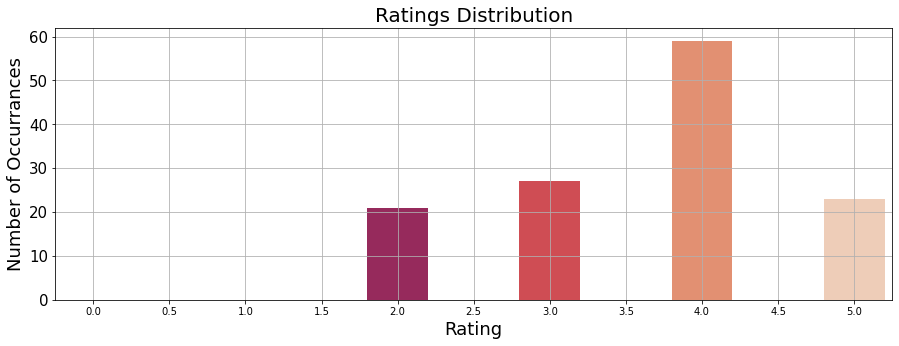

In [346]:
userId = 27
n_movies = 5

user_profile(userId, n_movies)

# Look at top 5 recommendations for all users 
- most common movies recommended

In [378]:
userIds = list(np.unique(np.array(ratings.userId)))
userIds = userIds[:40]
all_recs = []
for Id in userIds:
    all_recs.extend(recommend_to_user(Id, n_recs))

In [393]:
unique_movies = list(np.unique(np.array(all_recs)))
occurance_count = [all_recs.count(movie) for movie in unique_movies]
movie_rec_count = pd.DataFrame({'movie': unique_movies, 'rec_count': occurance_count}).sort_values(by='rec_count', ascending=False).set_index('movie')
movie_rec_count.head()
movie_rec_count = movie_rec_count[:10]

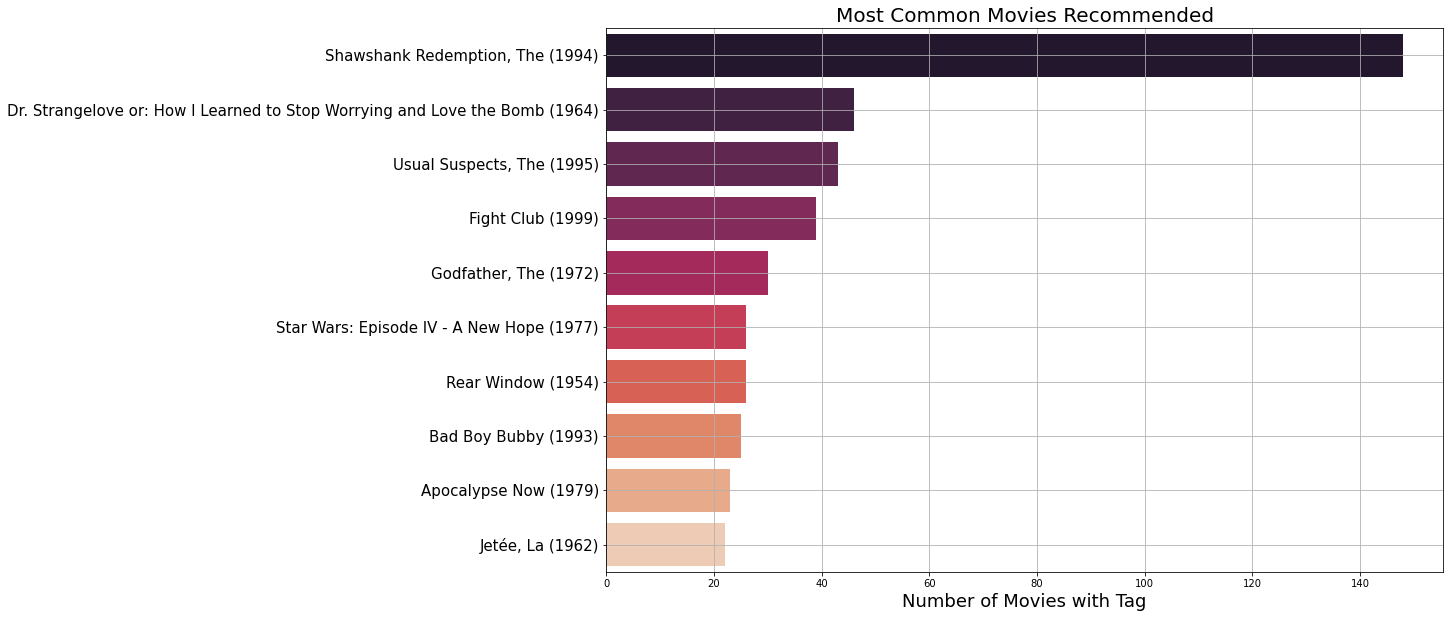

In [397]:
plt.figure(figsize=(15,10))
sns.barplot(data=movie_rec_count, x='rec_count', y=movie_rec_count.index, palette='rocket')
plt.yticks(fontsize=15)
plt.xlabel('Number of Movies with Tag', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('Most Common Movies Recommended', fontsize=20)
plt.grid()
plt.show()